In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null

In [7]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [8]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/content/32x32/train_normal/train_normal_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/content/32x32/train_attack/train_attack_*.jpg', recursive=True):
    train_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/content/32x32/test_normal/test_normal_*.jpg', recursive=True):
    test_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/content/32x32/test_attack/test_attack_*.jpg', recursive=True):
    test_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

train_normal = np.stack(train_normal)
train_attack = np.stack(train_attack)
test_normal = np.stack(test_normal)
test_attack = np.stack(test_attack)

In [9]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack),

((14992, 32, 32), (13020, 32, 32), (2164, 32, 32), (2854, 32, 32))

In [10]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack, train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90r_train_normal, rotate90l_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack, test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90r_test_normal, rotate90l_test_normal))

In [ ]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_attack))
test = np.vstack((test_normal, test_attack))

In [12]:
train.shape, test.shape

((140060, 32, 32), (25090, 32, 32))

In [11]:
train = train.reshape(-1,32,32,1)
test = test.reshape(-1,32,32,1)

In [12]:
train.shape, test.shape

((140060, 32, 32, 1), (25090, 32, 32, 1))

In [ ]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [ ]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [13]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [14]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(        attack  normal
 0            1       0
 1            1       0
 2            1       0
 3            1       0
 4            1       0
 ...        ...     ...
 140055       0       1
 140056       0       1
 140057       0       1
 140058       0       1
 140059       0       1
 
 [140060 rows x 2 columns],        attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 25085       0       1
 25086       0       1
 25087       0       1
 25088       0       1
 25089       0       1
 
 [25090 rows x 2 columns])

In [15]:
## shuffle the data to prevent pattern recognition
train = sklearn.utils.shuffle(train, random_state = 7)
ytrain = sklearn.utils.shuffle(ytrain, random_state = 7)

test = sklearn.utils.shuffle(test, random_state = 7)
ytest = sklearn.utils.shuffle(ytest, random_state = 7)

In [32]:
KERNEL_SIZE = [2,3]
IMAGE_SIZE = [32,32,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 2
cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 3
cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 4
cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.8))

## convolution 6
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (1,1)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 16)        112       
_________________________________________________________________
average_pooling2d_8 (Average (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        3104      
_________________________________________________________________
average_pooling2d_9 (Average (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          12352     
_________________________________________________________________
average_pooling2d_10 (Averag (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)        

In [33]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 1024, epochs = 200)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/200
137/137 [==============================] - 4s 23ms/step - loss: 0.7258 - accuracy: 0.5828
Epoch 2/200
137/137 [==============================] - 3s 21ms/step - loss: 0.6650 - accuracy: 0.6061
Epoch 3/200
137/137 [==============================] - 3s 21ms/step - loss: 0.6642 - accuracy: 0.6079
Epoch 4/200
137/137 [==============================] - 3s 21ms/step - loss: 0.6630 - accuracy: 0.6101
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: 0.6624 - accuracy: 0.6095
Epoch 6/200
137/137 [==============================] - 3s 22ms/step - loss: 0.6611 - accuracy: 0.6110
Epoch 7/200
137/137 [==============================] - 3s 21ms/step - loss: 0.6592 - accuracy: 0.6145
Epoch 8/200
137/137 [==============================] - 3s 21ms/step - loss: 0.6598 - accuracy: 0.6144
Epoch 9/200
137/137 [==============================] - 3s 21ms/step - loss: 0.6585 - accuracy: 0.6138
Epoch 10/200
137/137 [==============================] - 3s 22ms/step - loss: 0.656

dict_keys(['loss', 'accuracy'])


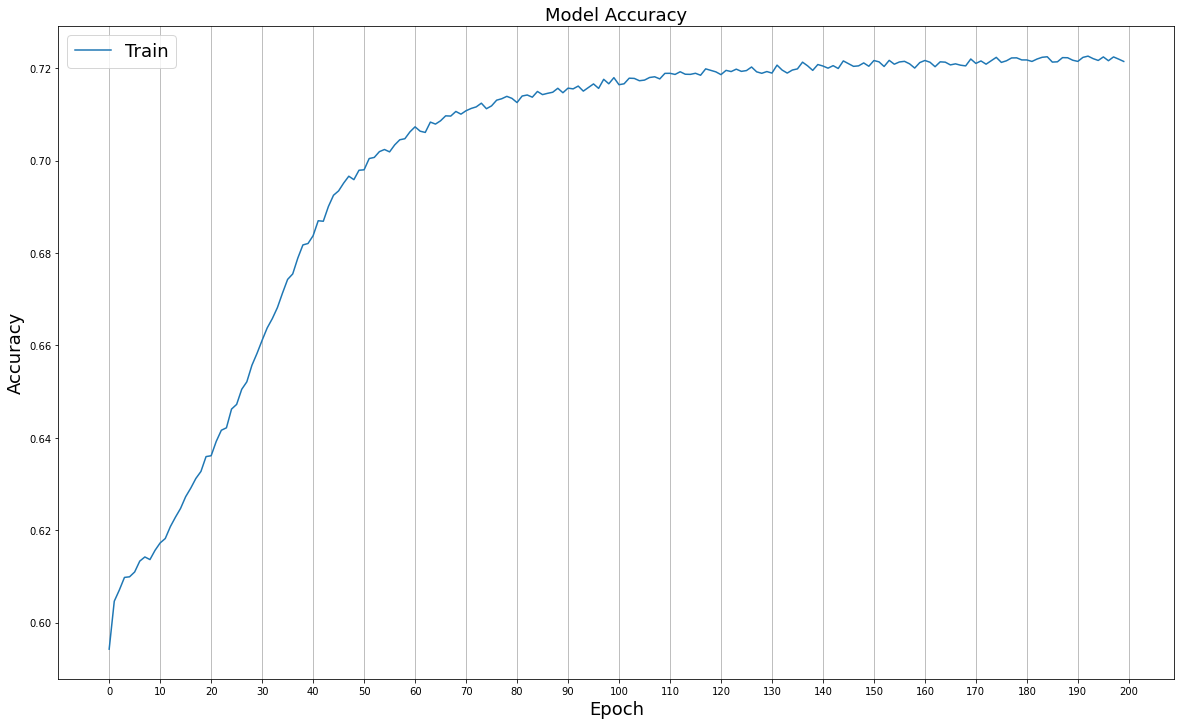

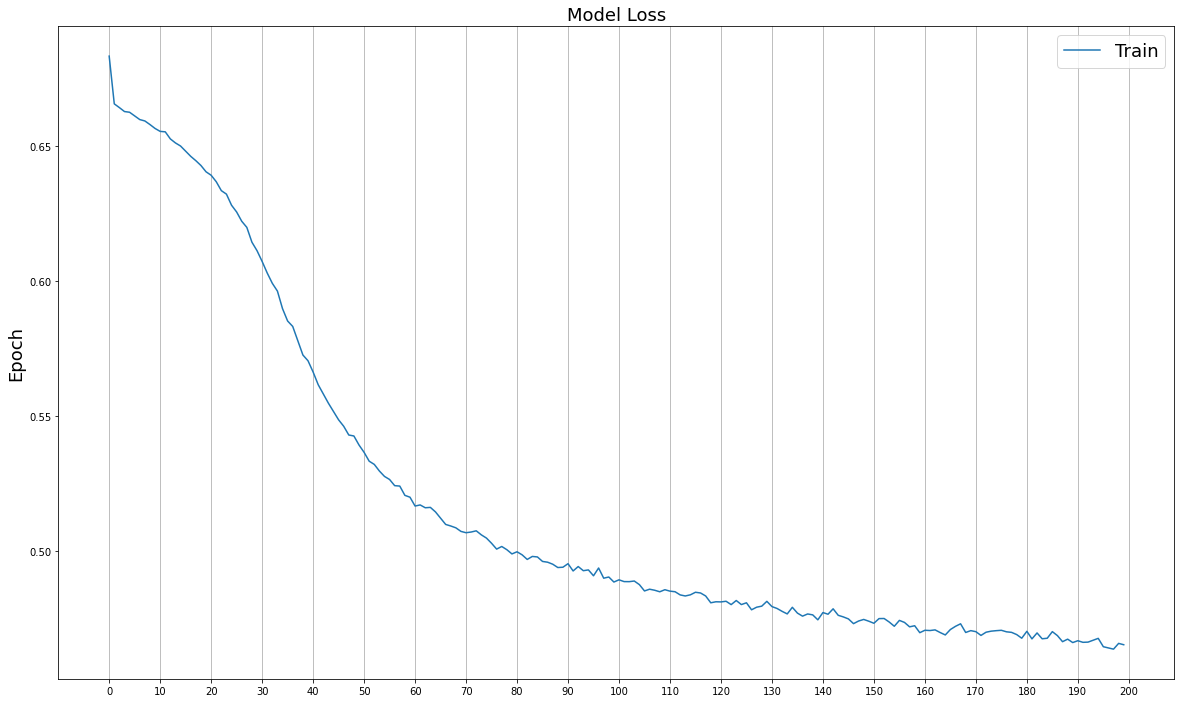

In [34]:
print(model_history.history.keys())

figure(figsize = (20,12))
plt.plot(model_history.history['accuracy'])
# plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10))
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

print()

figure(figsize = (20,12))
plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10), )
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

In [35]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 200, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.1808	Accuracy = 55.800000000000004%


In [36]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.33477, 0.66523],
       [0.4988 , 0.50112],
       [0.33477, 0.66523],
       [0.33477, 0.66523],
       [0.12319, 0.8769 ],
       [0.53572, 0.46427],
       [0.76021, 0.23994],
       [0.4988 , 0.50112],
       [0.81137, 0.18854],
       [0.33477, 0.66523],
       [0.4988 , 0.50112],
       [0.26431, 0.73565],
       [0.59861, 0.4014 ],
       [0.43684, 0.56301],
       [1.     , 0.     ],
       [0.49339, 0.5068 ],
       [0.54969, 0.45043],
       [1.     , 0.     ],
       [0.33477, 0.66523],
       [0.02166, 0.97827]], dtype=float32)

In [37]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(256, (3,3), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 6
    # cnn.add(Convolution2D(512, (2,2), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (1,1)))
    # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(256, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 1024, epochs = 200)

In [38]:
scores = cross_val_score(estimator = classifier, X = test, y = ytest, cv = 10, n_jobs = -1)
print(f'Model Cross Validation: \n{round(scores.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{scores}')

os.system('say "cross validation finished" ')

Model Cross Validation: 
49.6%
Model Cross Validation: 
[0.48984 0.48784 0.49462 0.499   0.50538 0.49542 0.50538 0.48784 0.50418
 0.49382]


32512